# Cuaderno 33: El problema del agente viajero múltiple ($k$-ATSP)

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$, donde $V= \{0, \ldots, n\}$;
* un número entero $k$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

El *problema del agente viajero asimétrico múltiple (Multiple Asymmetric Traveling Salesman Problem, $k$-ATSP)* consiste en encontrar un conjunto de $k$ circuitos dirigidos con las siguientes propiedades:
* todos los circuitos deben contener al nodo 0 (también conocido como *nodo base* o *nodo depósito*);
* cada uno de los demás nodos $1, \ldots, n$ debe pertenecer exactamente a un circuito; y,
* la suma de los costos de los arcos de todos los circuitos debe ser mínima.

Notar que para todos los nodos, con excepción del nodo depósito, se cumplen las mismas restricciones de grado entrante y saliente del ATSP. El grado entrante y el grado saliente en el nodo 0 deben ser ambos iguales a $k$.

Por otra parte, para impedir subciclos en una solución podemos usar las mismas estrategias que en el ATSP.
Emplearemos en este ejemplo desigualdades de corte: para todo conjunto de nodos $W \subset V$, con $\emptyset \neq W \neq V$, la solución debe contener al menos un arco del corte entrante $\delta^-(W)$ y al menos un arco del corte saliente $\delta^+(W)$, donde

\begin{align*}
\delta^-(W) &:= \{ (i, j) \in A \, : \, i \not\in W, j \in W \},\\
\delta^+(W) &:= \{ (i, j) \in A \, : \, i \in W, j \not\in W \}, 
\end{align*}


Utilizando variables binarias $x_{ij}$ para indicar la selección de arcos, el $k$-ATSP puede formularse como el siguiente programa lineal entero:

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(i,j) \in \delta^+(i) } x_{ij} = 1, \quad \forall i \in V \setminus \{0\},\\
&\sum_{(j,i) \in \delta^-(i) } x_{ji} = 1, \quad \forall i \in V \setminus \{0\},\\
&\sum_{(0,j) \in \delta^+(0) } x_{0j} = k,\\
&\sum_{(j,0) \in \delta^-(0) } x_{j0} = k,\\
&\sum_{(i,j) \in \delta^+(W)} x_{ij} \geq 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
&\sum_{(i,j) \in \delta^-(W)} x_{ij} \geq 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i,j) \in A.
\end{align*}

Vamos a implementar este modelo usando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` del módulo random para generar valores aleatorios en el rango {0,..,100} para las coordenadas de cada nodo. Los costos de los arcos serán iguales a las distancias euclideanas entre sus nodos extremos. 

In [1]:
from gurobipy import *
import random as rm
import math 

# Numero de nodos del grafo
n = 10

# Numero de toures en la solucion
k = 3

# Nodos del grafo
V = tuplelist(range(0,n+1))
# Nodos sin el depósito
V1 = tuplelist([i for i in V if i!=0])

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
# El depósito está en el centro
coordx={0 : 50}
coordy={0 : 50}
for i in V1:
    coordx[i] = rm.randint(0,100)
    coordy[i] = rm.randint(0,100)

# los costos son las distancias eculideanas
c = tupledict({})
for i in V:
    for j in V:
        # evitar lazos
        if i != j:
            c[i,j]= math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
 
A = c.keys()



Vamos a necesitar construir una restricción de corte para cada subconjunto de nodos $W \subset V$ tal que $\emptyset \neq W \neq V$. Con esta finalidad, definimos una función `powerset` empleando las funciones `chain` y `combinations` del módulo `itertools`.

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` indicando el orden de visita en la solución. Notar que en este caso, `tour` puede contener varias veces al nodo depósito.

In [3]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Definimos ahora el objeto modelo, las variables y la función objetivo:

In [10]:
# Crear el objeto modelo
m = Model('k-tsp-corte')

# Crear las variables
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)


Añadimos las restricciones de grado en los nodos distintos al depósito. 

In [11]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*') == 1 for i in V1), "g_saliente")

# Restricciones de grado entrante
m.addConstrs((x.sum('*', i) == 1 for i in V1), "g_entrante")


{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

Agregamos las restricciones de grado entrante y saliente en el depósito.

In [12]:
# Restriccion de grado saliente deposito
m.addConstr(x.sum(0,'*') == k, "d_saliente")

# Restriccion de grado entrante deposito
m.addConstr(x.sum('*', 0) == k, "d_entrante")


<gurobi.Constr *Awaiting Model Update*>

Para construir las restricciones de corte, usamos la función `powerset` para iterar sobre todos los subconjuntos de nodos $W$ tales que $\emptyset \neq W \neq V$. Para cada subconjunto, se construye primero el conjunto `Wc` con su 
complemento, es decir, con los nodos de $V$ que no están en $W$. La expresión `x.sum(W, Wc)` construye la suma de las variables asociadas a aristas que tienen el primer extremo en $W$ y el otro extremo fuera de $W$. De manera similar, `x.sum(Wc, W)` construye la suma de las variables asociadas a aristas que tienen el primer extremo fuera de $W$ y el otro extremo en $W$. Con estas expresiones construimos las restricciones de corte entrante y saliente.

In [13]:
# Restricciones de corte
PV = list(powerset(V))
for W in PV:
    if W!=() and W!=tuple(V):
        Wc = [i for i in V if i not in W]
        # Corte saliente
        m.addConstr(x.sum(W, Wc) >= 1, "corte_sal[{}]".format(W))
        # Corte entrante
        m.addConstr(x.sum(Wc, W) >= 1, "corte_ent[{}]".format(W))


Escribimos el modelo a un archivo de texto:

In [14]:
# Escribir el modelo a un archivo
m.write('k-tsp-corte.lp')


Finalmente, resolvemos el modelo y mostramos la solución:

In [15]:
# Calcular la solucion optima
m.optimize()

# Escribir la solucion
if m.status == GRB.Status.OPTIMAL:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nToures optimos:')
    for i,j in A:
        if vx[i,j] > 0:
            print('{} -> {}'.format(i, j))


Optimize a model with 4114 rows, 110 columns and 112860 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 562.6362614
Presolve removed 2068 rows and 0 columns
Presolve time: 0.07s
Presolved: 2046 rows, 110 columns, 56320 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)

Root relaxation: objective 2.740619e+02, 27 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     274.0618538  274.06185  0.00%     -    0s

Explored 0 nodes (27 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 274.062 562.636 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.74061

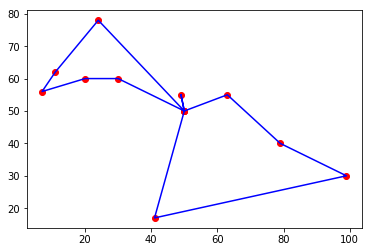

In [16]:
# Crear lista con arcos seleccionados en la solucion
L = [(i,j) for i,j in A if vx[i,j]>0]

# Recuperar el tour como un ordenamiento de los nodos que empieza y termina en el deposito
T = [0]
# nodo actual:
i = 0
while L!=[]:
    # Determinar un sucesor de i
    N = [j for j in V if (i,j) in L] 
    j = N.pop()
    a = (i,j)
    L.remove(a)
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Optimize a model with 4114 rows, 110 columns and 112860 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 558.8580325
Presolve removed 2068 rows and 0 columns
Presolve time: 0.07s
Presolved: 2046 rows, 110 columns, 56320 nonzeros
Variable types: 0 continuous, 110 integer (110 binary)

Root relaxation: objective 3.596320e+02, 31 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     359.6319549  359.63195  0.00%     -    0s

Explored 0 nodes (31 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 359.632 558.858 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.59631

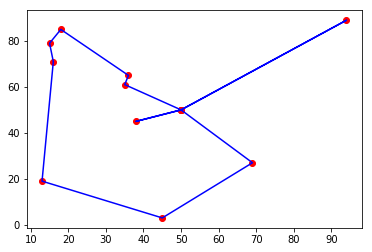

In [17]:
# Implementación de modelos lineales enteros
# Problema del agente viajero asimétrico múltiple (k-ATSP)

# Luis M. Torres (EPN 2019)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Numero de nodos del grafo
n = 10

# Numero de toures en la solucion
k = 3

# Nodos del grafo
V = tuplelist(range(0,n+1))
# Nodos sin el depósito
V1 = [i for i in V if i!=0]

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
# El depósito está en el centro
coordx={0 : 50}
coordy={0 : 50}
for i in V1:
    coordx[i] = rm.randint(0,100)
    coordy[i] = rm.randint(0,100)

# los costos son las distancias eculideanas
c = tupledict({})
for i in V:
    for j in V:
        # evitar lazos
        if i != j:
            c[i,j]= math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
 
A = c.keys()

try:
    # Crear el objeto modelo
    m = Model('k-tsp-corte')

    # Crear las variables
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*') == 1 for i in V1), "g_saliente")

    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i) == 1 for i in V1), "g_entrante")

    # Restriccion de grado saliente deposito
    m.addConstr(x.sum(0,'*') == k, "d_saliente")

    # Restriccion de grado entrante deposito
    m.addConstr(x.sum('*', 0) == k, "d_entrante")

    # Restricciones de corte
    PV = list(powerset(V))
    for W in PV:
        if W!=() and W!=tuple(V):
            Wc = [i for i in V if i not in W]
            # Corte saliente
            m.addConstr(x.sum(W, Wc) >= 1, "corte_sal[{}]".format(W))
            # Corte entrante
            m.addConstr(x.sum(Wc, W) >= 1, "corte_ent[{}]".format(W))

    # Escribir el modelo a un archivo
    # m.write('k-tsp-corte.lp')

    # Calcular la solucion optima
    m.optimize()

    # Escribir la solucion
    if m.status == GRB.Status.OPTIMAL:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nToures optimos:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} -> {}'.format(i, j))
                
    # Crear lista con arcos seleccionados en la solucion
    L = [(i,j) for i,j in A if vx[i,j]>0]

    # Recuperar el tour como un ordenamiento de los nodos que empieza y termina en el deposito
    T = [0]
    # nodo actual:
    i = 0
    while L!=[]:
        # Determinar un sucesor de i
        N = [j for j in V if (i,j) in L] 
        j = N.pop()
        a = (i,j) 
        L.remove(a)
        # Colocar sucesor en la lista del tour y actualizar i
        T.append(j)
        i = j
        
    # Graficar el tour
    dibujarTour(coordx, coordy, T)    

except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')

### Creando el conjunto potencia de un conjunto en Python

Para construir el conjunto potencia (la familia de subconjuntos) de cualquier iterable, pueden usarse las funciones `chain` y `combinations` del módulo `itertools`.

In [9]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

V = tuplelist([1, 2, 3, 4, 5])
L = list(powerset(V))
print V
print L

for W in L:
    if W!=() and W!=tuple(V):
        print W, len(W)

[1, 2, 3, 4, 5]
[(), (1,), (2,), (3,), (4,), (5,), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (1, 2, 3, 4, 5)]
(1,) 1
(2,) 1
(3,) 1
(4,) 1
(5,) 1
(1, 2) 2
(1, 3) 2
(1, 4) 2
(1, 5) 2
(2, 3) 2
(2, 4) 2
(2, 5) 2
(3, 4) 2
(3, 5) 2
(4, 5) 2
(1, 2, 3) 3
(1, 2, 4) 3
(1, 2, 5) 3
(1, 3, 4) 3
(1, 3, 5) 3
(1, 4, 5) 3
(2, 3, 4) 3
(2, 3, 5) 3
(2, 4, 5) 3
(3, 4, 5) 3
(1, 2, 3, 4) 4
(1, 2, 3, 5) 4
(1, 2, 4, 5) 4
(1, 3, 4, 5) 4
(2, 3, 4, 5) 4
